In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os
from collections import Counter

# Step 1: Unzip dataset
zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Set dataset_dir to the extracted folder containing classes
dataset_dir = '/content/dataset/eye reaction last'

# Step 3: List class folders inside dataset_dir
print("Classes in dataset directory:")
classes = os.listdir(dataset_dir)
print(classes)

# Step 4: Check class distribution by counting files in each class folder
print("\nClass distribution:")
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        print(f"Class '{cls}': {num_files} images")


Classes in dataset directory:
['train', 'test']

Class distribution:
Class 'train': 6 images
Class 'test': 6 images


In [ ]:
train_path = '/content/dataset/eye reaction last/train'
test_path = '/content/dataset/eye reaction last/test'

print("Train folder contents:", os.listdir(train_path))
print("Test folder contents:", os.listdir(test_path))


Train folder contents: ['anger', 'fear', 'surprise', 'sad', 'happy', 'disgust']
Test folder contents: ['anger', 'fear', 'surprise', 'sad', 'happy', 'disgust']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
train_dir = '/content/dataset/eye reaction last/train'
test_dir = '/content/dataset/eye reaction last/test'


In [ ]:
#DATA AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

img_height, img_width = 224, 224
batch_size = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Test data generator - no augmentation, only preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 270 images belonging to 6 classes.
Found 138 images belonging to 6 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#MODEL TRAINING
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet50_emotion_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1894 - loss: 2.6223
Epoch 1: val_loss improved from inf to 1.73770, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.1890 - loss: 2.6053 - val_accuracy: 0.2681 - val_loss: 1.7377
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2365 - loss: 2.2828
Epoch 2: val_loss improved from 1.73770 to 1.52604, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2391 - loss: 2.2772 - val_accuracy: 0.3768 - val_loss: 1.5260
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2153 - loss: 1.9730
Epoch 3: val_loss improved from 1.52604 to 1.43432, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2182 - loss: 1.9685 - val_accuracy: 0.4348 - val_loss: 1.4343
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.3000 - loss: 1.7981
Epoch 4: val_loss improved from 1.43432 to 1.39769, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3026 - loss: 1.7936 - val_accuracy: 0.4203 - val_loss: 1.3977
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.3578 - loss: 1.7166
Epoch 5: val_loss improved from 1.39769 to 1.30888, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step - accuracy: 0.3587 - loss: 1.7125 - val_accuracy: 0.4783 - val_loss: 1.3089
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.4056 - loss: 1.6088
Epoch 6: val_loss improved from 1.30888 to 1.25286, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4054 - loss: 1.6049 - val_accuracy: 0.5362 - val_loss: 1.2529
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.4296 - loss: 1.4470
Epoch 7: val_loss improved from 1.25286 to 1.21438, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 775ms/step - accuracy: 0.4307 - loss: 1.4416 - val_accuracy: 0.5507 - val_loss: 1.2144
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4145 - loss: 1.5166
Epoch 8: val_loss improved from 1.21438 to 1.18017, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 665ms/step - accuracy: 0.4156 - loss: 1.5127 - val_accuracy: 0.5725 - val_loss: 1.1802
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5130 - loss: 1.2979
Epoch 9: val_loss improved from 1.18017 to 1.12201, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 780ms/step - accuracy: 0.5117 - loss: 1.2992 - val_accuracy: 0.5797 - val_loss: 1.1220
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.5247 - loss: 1.2271
Epoch 10: val_loss improved from 1.12201 to 1.08761, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - accuracy: 0.5226 - loss: 1.2397 - val_accuracy: 0.6087 - val_loss: 1.0876
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4449 - loss: 1.3865
Epoch 11: val_loss improved from 1.08761 to 1.05501, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 764ms/step - accuracy: 0.4493 - loss: 1.3768 - val_accuracy: 0.6232 - val_loss: 1.0550
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.5694 - loss: 1.1354
Epoch 12: val_loss improved from 1.05501 to 1.03649, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 630ms/step - accuracy: 0.5672 - loss: 1.1408 - val_accuracy: 0.6232 - val_loss: 1.0365
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5696 - loss: 1.1890
Epoch 13: val_loss improved from 1.03649 to 1.02113, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 648ms/step - accuracy: 0.5708 - loss: 1.1867 - val_accuracy: 0.6594 - val_loss: 1.0211
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.5585 - loss: 1.2145
Epoch 14: val_loss improved from 1.02113 to 0.99474, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.5564 - loss: 1.2150 - val_accuracy: 0.6449 - val_loss: 0.9947
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.5344 - loss: 1.2106
Epoch 15: val_loss improved from 0.99474 to 0.97992, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 652ms/step - accuracy: 0.5350 - loss: 1.2054 - val_accuracy: 0.6304 - val_loss: 0.9799
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5524 - loss: 1.1240
Epoch 16: val_loss improved from 0.97992 to 0.96139, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 764ms/step - accuracy: 0.5531 - loss: 1.1276 - val_accuracy: 0.6739 - val_loss: 0.9614
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6182 - loss: 0.9949
Epoch 17: val_loss improved from 0.96139 to 0.95050, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - accuracy: 0.6168 - loss: 0.9990 - val_accuracy: 0.6667 - val_loss: 0.9505
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6278 - loss: 1.1544
Epoch 18: val_loss improved from 0.95050 to 0.93332, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 791ms/step - accuracy: 0.6269 - loss: 1.1510 - val_accuracy: 0.6812 - val_loss: 0.9333
Epoch 19/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.5730 - loss: 1.1024
Epoch 19: val_loss improved from 0.93332 to 0.91971, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 622ms/step - accuracy: 0.5757 - loss: 1.0987 - val_accuracy: 0.6739 - val_loss: 0.9197
Epoch 20/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.6026 - loss: 1.0375
Epoch 20: val_loss improved from 0.91971 to 0.91746, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 793ms/step - accuracy: 0.6049 - loss: 1.0354 - val_accuracy: 0.6739 - val_loss: 0.9175
Epoch 21/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.6489 - loss: 0.9762
Epoch 21: val_loss improved from 0.91746 to 0.91298, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 681ms/step - accuracy: 0.6485 - loss: 0.9764 - val_accuracy: 0.6812 - val_loss: 0.9130
Epoch 22/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.6433 - loss: 0.9828
Epoch 22: val_loss improved from 0.91298 to 0.88274, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 792ms/step - accuracy: 0.6397 - loss: 0.9870 - val_accuracy: 0.7029 - val_loss: 0.8827
Epoch 23/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.6502 - loss: 0.9378
Epoch 23: val_loss improved from 0.88274 to 0.86040, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 617ms/step - accuracy: 0.6481 - loss: 0.9427 - val_accuracy: 0.6884 - val_loss: 0.8604
Epoch 24/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.6537 - loss: 0.9175
Epoch 24: val_loss did not improve from 0.86040
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 715ms/step - accuracy: 0.6527 - loss: 0.9236 - val_accuracy: 0.7101 - val_loss: 0.8657
Epoch 25/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6607 - loss: 1.0141
Epoch 25: val_loss improved from 0.86040 to 0.85638, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 618ms/step - accuracy: 0.6598 - loss: 1.0107 - val_accuracy: 0.7029 - val_loss: 0.8564
Epoch 26/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6829 - loss: 0.9081
Epoch 26: val_loss improved from 0.85638 to 0.85485, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 686ms/step - accuracy: 0.6827 - loss: 0.9099 - val_accuracy: 0.7174 - val_loss: 0.8548
Epoch 27/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.6602 - loss: 0.8675
Epoch 27: val_loss improved from 0.85485 to 0.83932, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 659ms/step - accuracy: 0.6605 - loss: 0.8700 - val_accuracy: 0.6884 - val_loss: 0.8393
Epoch 28/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6351 - loss: 0.9295
Epoch 28: val_loss improved from 0.83932 to 0.82592, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - accuracy: 0.6364 - loss: 0.9290 - val_accuracy: 0.7101 - val_loss: 0.8259
Epoch 29/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6439 - loss: 0.8865
Epoch 29: val_loss improved from 0.82592 to 0.82518, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step - accuracy: 0.6439 - loss: 0.8866 - val_accuracy: 0.7319 - val_loss: 0.8252
Epoch 30/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.6811 - loss: 0.8543
Epoch 30: val_loss did not improve from 0.82518
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step - accuracy: 0.6811 - loss: 0.8580 - val_accuracy: 0.7101 - val_loss: 0.8313


In [ ]:
#fine tune some of the base ResNet50 layers
# Unfreeze last 20 layers of base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=callbacks  # reuse early stopping and checkpointing callbacks
)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6891 - loss: 0.9610
Epoch 1: val_loss improved from 0.82518 to 0.81911, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6887 - loss: 0.9600 - val_accuracy: 0.7319 - val_loss: 0.8191
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.6524 - loss: 0.9758
Epoch 2: val_loss improved from 0.81911 to 0.81518, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - accuracy: 0.6538 - loss: 0.9719 - val_accuracy: 0.7246 - val_loss: 0.8152
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.7145 - loss: 0.9049
Epoch 3: val_loss improved from 0.81518 to 0.80826, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 802ms/step - accuracy: 0.7116 - loss: 0.9055 - val_accuracy: 0.7246 - val_loss: 0.8083
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6793 - loss: 0.8942
Epoch 4: val_loss improved from 0.80826 to 0.79987, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - accuracy: 0.6758 - loss: 0.8961 - val_accuracy: 0.7319 - val_loss: 0.7999
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6172 - loss: 0.9525
Epoch 5: val_loss improved from 0.79987 to 0.79363, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 780ms/step - accuracy: 0.6247 - loss: 0.9474 - val_accuracy: 0.7391 - val_loss: 0.7936
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.6217 - loss: 0.9714
Epoch 6: val_loss improved from 0.79363 to 0.78666, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 630ms/step - accuracy: 0.6225 - loss: 0.9658 - val_accuracy: 0.7464 - val_loss: 0.7867
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6642 - loss: 0.8967
Epoch 7: val_loss improved from 0.78666 to 0.77917, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 786ms/step - accuracy: 0.6649 - loss: 0.8937 - val_accuracy: 0.7536 - val_loss: 0.7792
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6942 - loss: 0.8628
Epoch 8: val_loss improved from 0.77917 to 0.77296, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.6926 - loss: 0.8629 - val_accuracy: 0.7609 - val_loss: 0.7730
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7327 - loss: 0.7805
Epoch 9: val_loss improved from 0.77296 to 0.76874, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step - accuracy: 0.7324 - loss: 0.7820 - val_accuracy: 0.7609 - val_loss: 0.7687
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7344 - loss: 0.8041
Epoch 10: val_loss improved from 0.76874 to 0.76452, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - accuracy: 0.7354 - loss: 0.8003 - val_accuracy: 0.7681 - val_loss: 0.7645
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6925 - loss: 0.8676
Epoch 11: val_loss improved from 0.76452 to 0.76060, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 726ms/step - accuracy: 0.6925 - loss: 0.8676 - val_accuracy: 0.7536 - val_loss: 0.7606
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7641 - loss: 0.7758
Epoch 12: val_loss improved from 0.76060 to 0.75543, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 650ms/step - accuracy: 0.7607 - loss: 0.7757 - val_accuracy: 0.7536 - val_loss: 0.7554
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7323 - loss: 0.7995
Epoch 13: val_loss improved from 0.75543 to 0.75258, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 665ms/step - accuracy: 0.7324 - loss: 0.7995 - val_accuracy: 0.7536 - val_loss: 0.7526
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.7051 - loss: 0.7836
Epoch 14: val_loss did not improve from 0.75258
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step - accuracy: 0.7072 - loss: 0.7814 - val_accuracy: 0.7536 - val_loss: 0.7528
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6926 - loss: 0.8159
Epoch 15: val_loss improved from 0.75258 to 0.74512, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 647ms/step - accuracy: 0.6952 - loss: 0.8131 - val_accuracy: 0.7536 - val_loss: 0.7451
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.7392 - loss: 0.6937
Epoch 16: val_loss improved from 0.74512 to 0.73978, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 816ms/step - accuracy: 0.7412 - loss: 0.6933 - val_accuracy: 0.7609 - val_loss: 0.7398
Epoch 17/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7542 - loss: 0.8218
Epoch 17: val_loss improved from 0.73978 to 0.73249, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 676ms/step - accuracy: 0.7540 - loss: 0.8158 - val_accuracy: 0.7536 - val_loss: 0.7325
Epoch 18/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.6940 - loss: 0.7855
Epoch 18: val_loss improved from 0.73249 to 0.72812, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 802ms/step - accuracy: 0.6975 - loss: 0.7791 - val_accuracy: 0.7536 - val_loss: 0.7281
Epoch 19/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7533 - loss: 0.7265
Epoch 19: val_loss improved from 0.72812 to 0.72239, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 648ms/step - accuracy: 0.7550 - loss: 0.7236 - val_accuracy: 0.7609 - val_loss: 0.7224
Epoch 20/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.7053 - loss: 0.7405
Epoch 20: val_loss improved from 0.72239 to 0.71751, saving model to best_resnet50_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 816ms/step - accuracy: 0.7036 - loss: 0.7413 - val_accuracy: 0.7681 - val_loss: 0.7175


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Accuracy: 0.7681
Precision: 0.7862
Recall: 0.7681
F1 Score: 0.7682
Cohen's Kappa: 0.7176

Classification Report:

              precision    recall  f1-score   support

       anger       0.75      0.89      0.81        27
     disgust       0.60      0.60      0.60        15
        fear       0.77      0.87      0.82        23
       happy       0.88      0.82      0.85        34
         sad       1.00      0.62      0.76        21
    surprise       0.60      0.67      0.63        18

    accuracy                           0.77       138
   macro avg       0.77      0.74      0.75       138
weighted avg       0.79      0.77      0.77       138



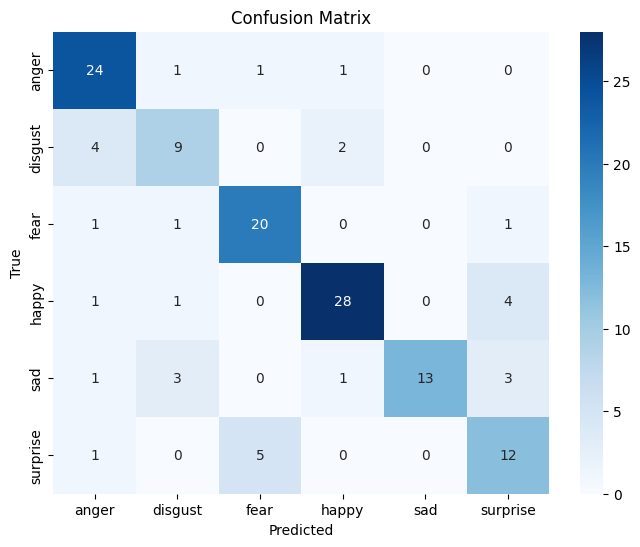

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load best model if needed
# from tensorflow.keras.models import load_model
# model = load_model('best_resnet50_emotion_model.h5')

# Predict on test set
test_generator.reset()
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_prob = model.predict(test_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Metrics
accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')
kappa = cohen_kappa_score(Y_true, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix plot
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


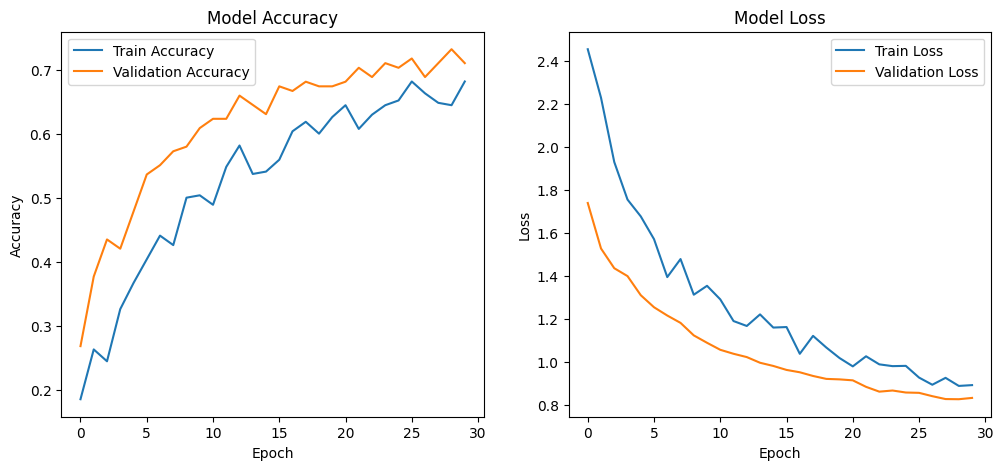

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step


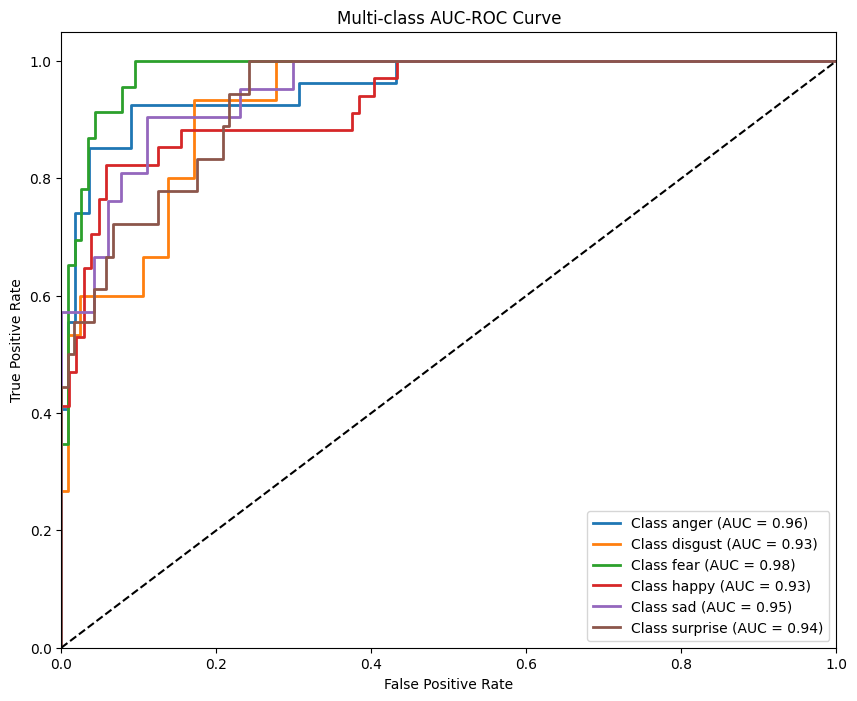

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get class labels from generator
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
num_classes = len(class_labels)

# Step 2: Predict probabilities for test set
y_pred = model.predict(test_generator, verbose=1)

# Step 3: Get true labels
y_true = test_generator.classes
y_true = label_binarize(y_true, classes=list(range(num_classes)))

# Step 4: Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from google.colab import files

uploaded = files.upload()  # Upload multiple images
image_paths = list(uploaded.keys())
print(f"Uploaded files: {image_paths}")


Saving test anger.jpg to test anger.jpg
Saving test disgust.jpg to test disgust.jpg
Saving test fear.jpg to test fear.jpg
Saving test happy.jpg to test happy.jpg
Saving test sad.jpg to test sad.jpg
Saving test surprise.jpg to test surprise.jpg
Uploaded files: ['test anger.jpg', 'test disgust.jpg', 'test fear.jpg', 'test happy.jpg', 'test sad.jpg', 'test surprise.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Image: test anger.jpg
Detected emotion: anger
Confidence: 0.9948


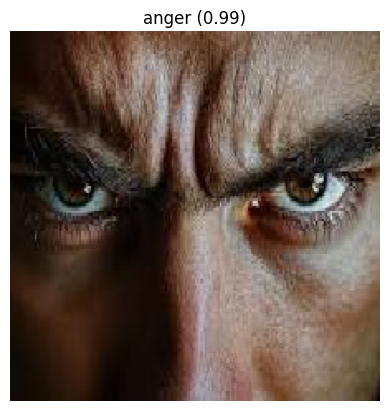

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: test disgust.jpg
Detected emotion: happy
Confidence: 0.4459


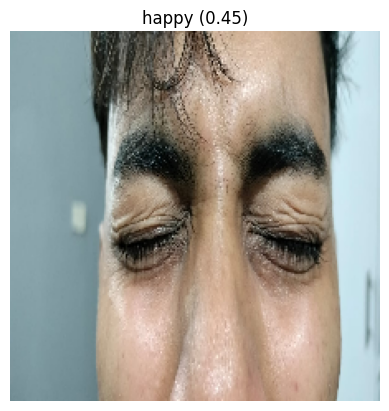

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: test fear.jpg
Detected emotion: fear
Confidence: 0.8953


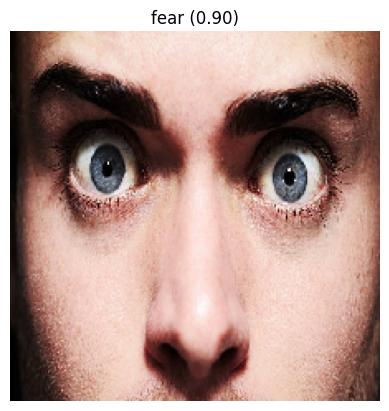

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: test happy.jpg
Detected emotion: happy
Confidence: 0.7899


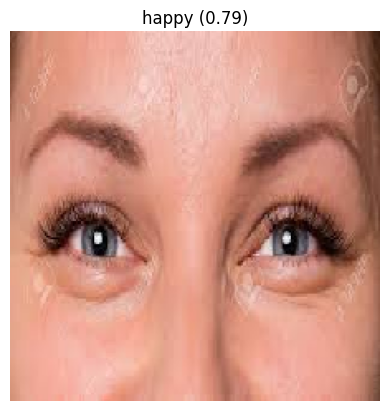

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: test sad.jpg
Detected emotion: anger
Confidence: 0.5722


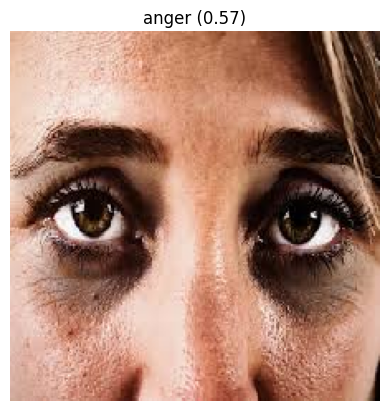

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: test surprise.jpg
Detected emotion: fear
Confidence: 0.3070


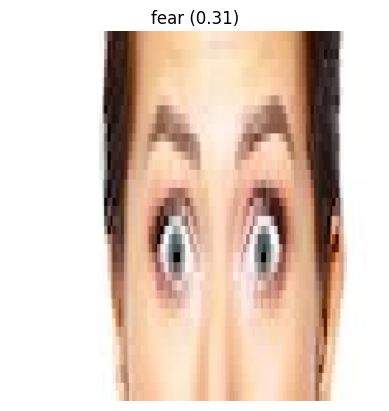

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

class_indices = test_generator.class_indices
# Map indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

img_height, img_width = 224, 224

for img_path in image_paths:
    # Load and preprocess image
    img = load_img(img_path, target_size=(img_height, img_width))
    plt.imshow(img)
    plt.axis('off')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    # Prediction
    preds = model.predict(img_preprocessed)
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx]

    print(f"Image: {img_path}")
    print(f"Detected emotion: {class_labels[class_idx]}")
    print(f"Confidence: {confidence:.4f}")

    plt.title(f"{class_labels[class_idx]} ({confidence:.2f})")
    plt.show()


In [ ]:
import tensorflow as tf
import cv2

def generate_gradcam(model, img_path, last_conv_layer_name, preprocess_func=preprocess_input, img_size=(224,224)):
    """
    Generates Grad-CAM heatmap for a given image and model.

    Args:
        model: Trained Keras model
        img_path: Path to the image file
        last_conv_layer_name: Name of the last conv layer in the model (for ResNet50 it's 'conv5_block3_out')
        preprocess_func: Preprocessing function (e.g., preprocess_input for ResNet50)
        img_size: Target size for resizing image (default (224,224))
    """
    # Load and preprocess image
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)

    # Predict class
    preds = model.predict(img_array)
    pred_index = np.argmax(preds[0])

    # Get last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply channel importance by feature map
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Average over channels to get heatmap
    heatmap = np.mean(conv_outputs, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() if heatmap.max() != 0 else 1

    # Load original image for overlay
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose heatmap onto original image
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

    # Display results
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM\nPrediction: {class_labels[pred_index]}")
    plt.axis("off")
    plt.show()

    return preds, class_labels[pred_index]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


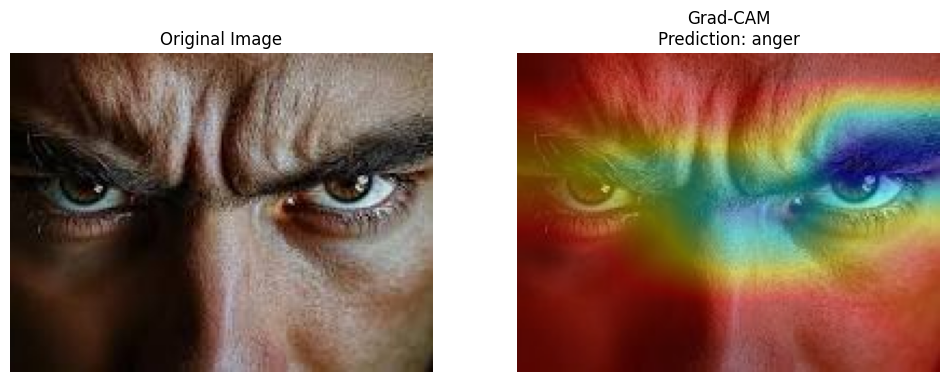

test anger.jpg → Predicted: anger (0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


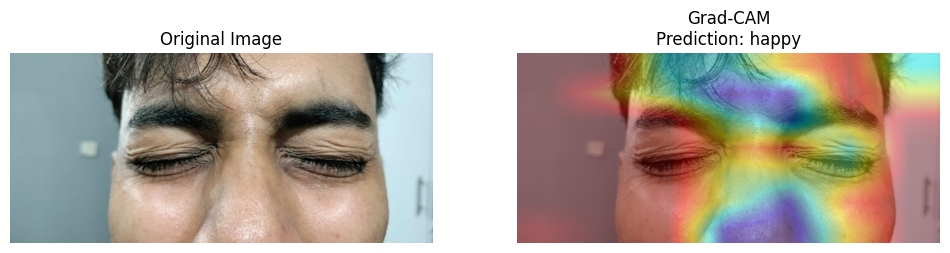

test disgust.jpg → Predicted: happy (0.45)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


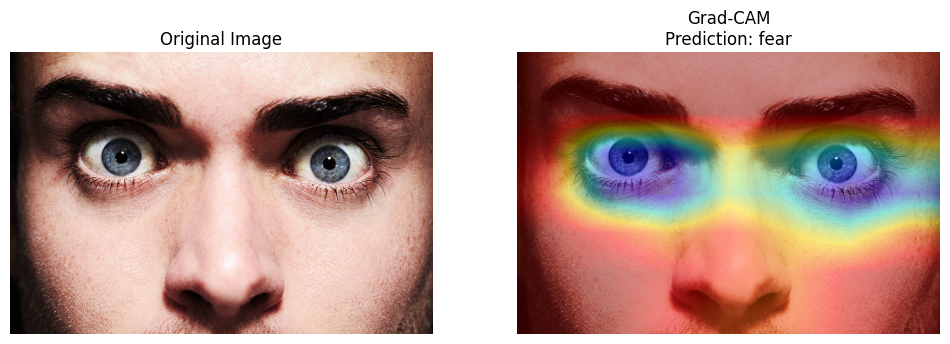

test fear.jpg → Predicted: fear (0.90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


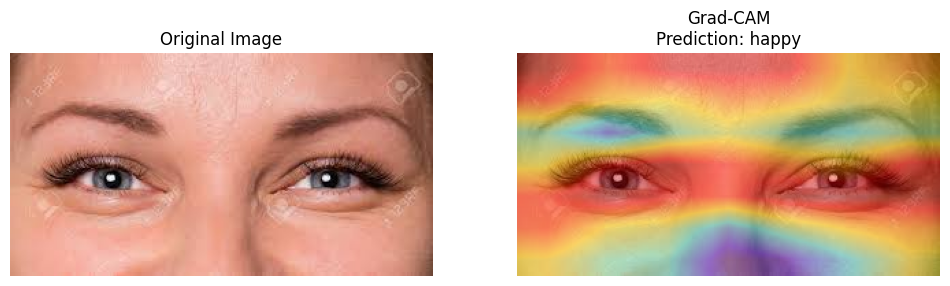

test happy.jpg → Predicted: happy (0.79)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


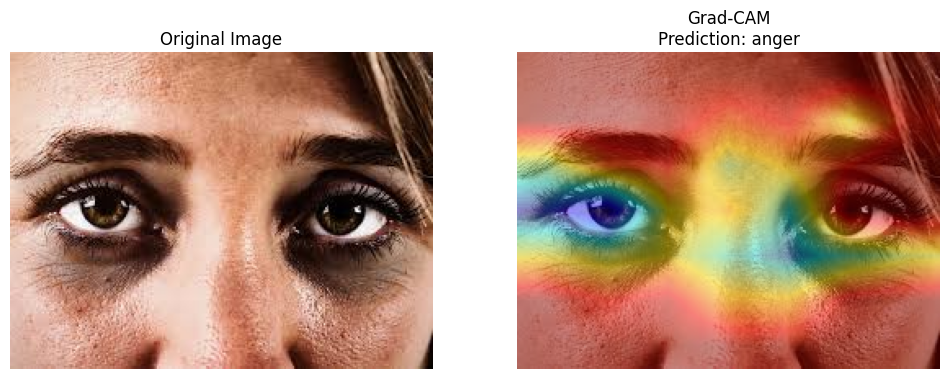

test sad.jpg → Predicted: anger (0.57)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


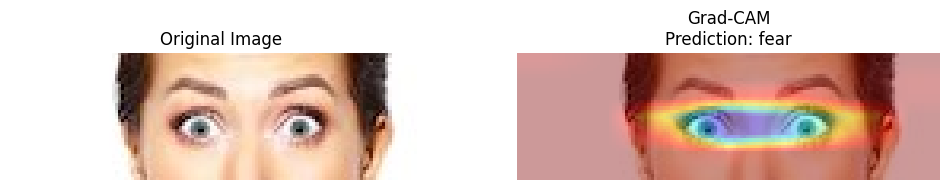

test surprise.jpg → Predicted: fear (0.31)


In [ ]:
# Example: Generate Grad-CAM for all uploaded images
for img_path in image_paths:
    preds, pred_class = generate_gradcam(
        model,
        img_path,
        last_conv_layer_name="conv5_block3_out",  # last conv layer for ResNet50
        preprocess_func=preprocess_input,
        img_size=(224,224)
    )
    print(f"{img_path} → Predicted: {pred_class} ({np.max(preds[0]):.2f})")


In [ ]:
model.save("resnet50_eye_emotion_version2.h5")


In [ ]:
from google.colab import files
files.download("resnet50_eye_emotion_version2.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>